In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 2. Imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import os

In [3]:
# 3. Set Parameters
img_size = (100, 100)
batch_size = 16
dataset_path = '/content/drive/MyDrive/Trainopia/Five_Faces/Reem1'

In [4]:
# 4. Prepare Data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Save label mapping
class_indices = train_gen.class_indices
idx_to_label = {v: k for k, v in class_indices.items()}

Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [5]:
# 5. Load Pretrained MobileNetV2
base_model = MobileNetV2(input_shape=(100, 100, 3), include_top=False, weights='imagenet')
base_model.trainable = False

<ipython-input-5-cd2bdf44e911>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(100, 100, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# 6. Add Classification Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# 7. Train the Model
model.fit(train_gen, validation_data=val_gen, epochs=5)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.4806 - loss: 1.3303 - val_accuracy: 0.6000 - val_loss: 0.7652
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - accuracy: 0.6373 - loss: 0.6804 - val_accuracy: 0.6500 - val_loss: 0.6323
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.7049 - loss: 0.5843 - val_accuracy: 0.6000 - val_loss: 0.5898
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 544ms/step - accuracy: 0.7516 - loss: 0.5054 - val_accuracy: 0.7000 - val_loss: 0.9723
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - accuracy: 0.7528 - loss: 0.5587 - val_accuracy: 0.8500 - val_loss: 0.2722


In [9]:
# 8. Save the Model to Google Drive
model_save_path = '/content/drive/MyDrive/Trainopia/face_recognition_mobilenetv22.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/Trainopia/face_recognition_mobilenetv22.h5


In [11]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/drive/MyDrive/Trainopia/face_recognition_mobilenetv22.h5')

In [13]:
from google.colab import files
uploaded = files.upload()

Saving musk0.jpg to musk0.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


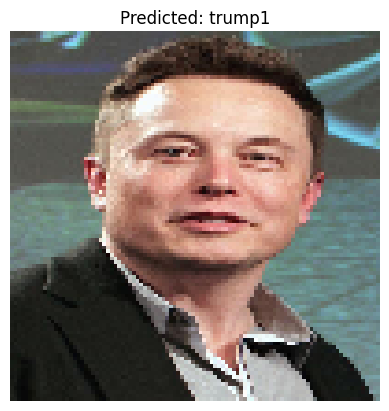

In [14]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Predict each uploaded image
for img_name in uploaded.keys():
    img = image.load_img(img_name, target_size=(100, 100))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    pred = model.predict(img_array)
    predicted_class_index = np.argmax(pred[0])
    predicted_label = idx_to_label[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}")
    plt.show()